<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula05b_MLP_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

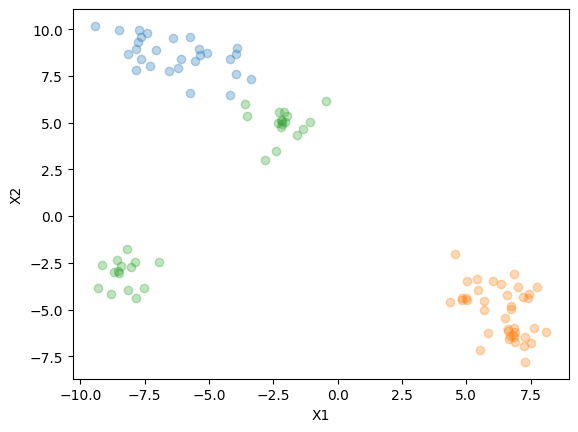

In [88]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def criaDatasetBidimensionalBinárioNãoLinearmenteSeparável(n=20, n_classes=3):
    """
    Cria um dataset bidimensional Binário não linearmente separável.
    """
    X, y = make_blobs(n_samples=n, centers=n_classes*2, cluster_std=0.8)
    y = np.array(y%n_classes, dtype=int)
    return X, y

X, y = criaDatasetBidimensionalBinárioNãoLinearmenteSeparável(1000)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)


def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

def define_axes(X):
    offset = 0.2
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [89]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [131]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

from abc import ABC, abstractstaticmethod

class ActivationFunction(ABC):
  @abstractstaticmethod
  def forward(a):
    pass
  @abstractstaticmethod
  def backward(a):
    pass
  @abstractstaticmethod
  def decision(a):
    pass

class Tanh(ActivationFunction):
  @staticmethod
  def forward(a):
    return expit(a) * 2 -1
  @staticmethod
  def backward(a):
    return (1 - np.square(Tanh.forward(a)))
  @staticmethod
  def decision(a):
    return (a >= 0) * 2 -1

class Sigmoid(ActivationFunction):
  @staticmethod
  def forward(a):
    return expit(a)
  @staticmethod
  def backward(a):
    return Sigmoid.forward(a) * (1 - Sigmoid.forward(a))
  @staticmethod
  def decision(a):
    return (a >= 0.5) * 2 - 1


In [141]:
def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Backpropagation():
  def __init__(self, n_hidden=2, 
               learning_rate= 0.005, 
               max_iter=1000,
               activation=Tanh()):
    self.n_hidden = n_hidden
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.activation = activation

  def forward(self):
    self.pH = self.Xb @ self.ihw
    self.H = self.activation.forward(self.pH)
    self.Hb = include_bias(self.H)
    self.prey = self.Hb @ self.how
    self.posy = self.activation.forward(self.prey)
    self.ypred = self.activation.decision(self.posy)
  
  def backward(self, y):
    ho_delta = y - self.ypred
    ho_grad = self.Hb.T @ ho_delta
    deriv_grad = self.activation.backward(self.pH)
    ih_delta = (ho_delta @ self.how[1:,:].T) * deriv_grad
    ih_grad = self.Xb.T @ ih_delta
    self.how += ho_grad * self.learning_rate
    self.ihw += ih_grad * self.learning_rate

  def fit(self, X, y):
    self.Xb = include_bias(X)
    self.ihw = np.random.uniform(-1, 1, size=(self.Xb.shape[1], self.n_hidden))
    self.how = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1]))
    for _ in range(self.max_iter):
      self.forward()
      self.backward(y)

  def predict(self, X):
    Xb = include_bias(X)
    H = self.activation.forward(Xb @ self.ihw)
    Hb = include_bias(H)
    prey = Hb @ self.how
    posy = self.activation.forward(prey)
    return self.activation.decision(posy)

1.0
1.0


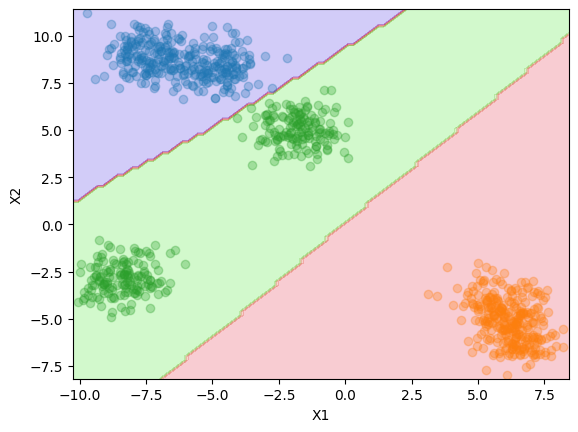

In [127]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=Backpropagation()):
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)
    return self

  def predict(self, X):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <= 2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

elm = MLP(Backpropagation(5, 0.001))
elm.fit(Xtr, ytr)
print(accuracy(ytr, elm.predict(Xtr)))
plotaDatasetBidimensional(Xte, yte)
plot_predictions(elm, Xte)
print(accuracy(yte, elm.predict(Xte)))

1.0
0.9966666666666667


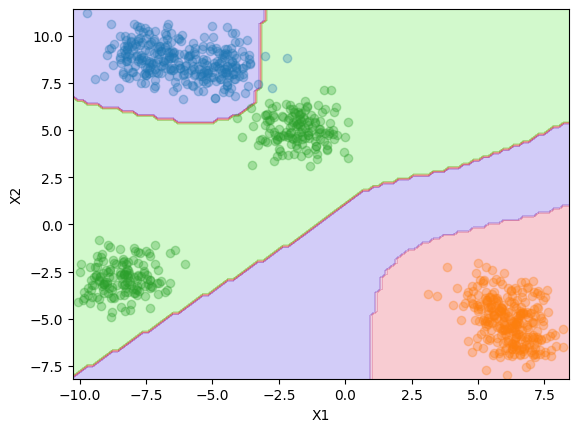

In [142]:
elm = MLP(Backpropagation(5, 0.001, max_iter=1000, activation=Sigmoid()))
elm.fit(Xtr, ytr)
print(accuracy(ytr, elm.predict(Xtr)))
plotaDatasetBidimensional(Xte, yte)
plot_predictions(elm, Xte)
print(accuracy(yte, elm.predict(Xte)))